# Bloque II — Fundamentos Cuantitativos  
## 3.3 Procesos Estocásticos Básicos  
**Generación de trayectorias mediante Random Walk, Movimiento Browniano y Procesos de Poisson**

### Objetivo de la clase  
Entender los procesos estocásticos fundamentales que sirven como bloques de construcción para modelos financieros más complejos (como el GBM visto anteriormente). Aprenderemos a simular y visualizar:

- **Random Walk** (paseo aleatorio) en tiempo discreto.  
- **Movimiento Browniano** (Wiener Process) en tiempo continuo.  
- **Procesos de Poisson** para modelar eventos discretos y shocks.

Estos procesos nos permitirán describir la evolución aleatoria de activos, la llegada de noticias o saltos en los precios, y sentar las bases para modelos más avanzados (difusiones con saltos, procesos de Lévy, etc.).

---

## 1. Random Walk (Paseo Aleatorio) en Tiempo Discreto

El **Random Walk** es el proceso estocástico más sencillo. En finanzas, se relaciona con la hipótesis de mercado eficiente: los precios siguen un camino aleatorio impredecible.

### Definición  
Un paseo aleatorio unidimensional (con drift) se define como:
$$
S_t = S_{t-1} + \mu + \sigma \epsilon_t, \quad \epsilon_t \sim \text{i.i.d.}, \quad \mathbb{E}[\epsilon_t]=0, \ \text{Var}(\epsilon_t)=1
$$

Donde:
- $\mu$ es la tendencia (drift) por paso.
- $\sigma$ es la volatilidad por paso.
- Comúnmente se usa $\epsilon_t \sim \mathcal{N}(0,1)$ o $\epsilon_t = \pm 1$ con igual probabilidad (random walk simétrico).

### Propiedades importantes
- **No estacionariedad en media** si $\mu \neq 0$.
- **Varianza creciente linealmente** con el tiempo: $\text{Var}(S_t) = \sigma^2 t$.
- Los incrementos son independientes.

### Simulación de un Random Walk

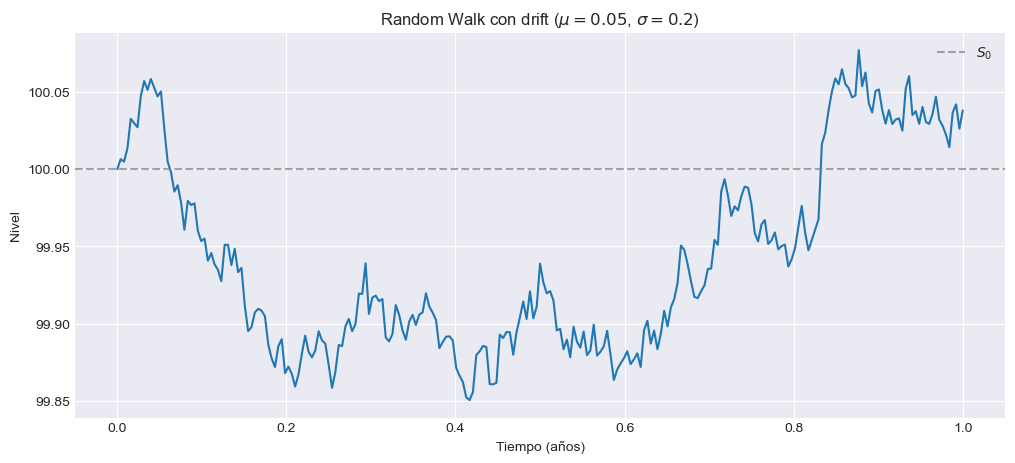

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

# Parámetros
T = 1.0            # horizonte temporal (años)
n_steps = 252      # pasos (días de trading)
dt = T / n_steps
mu = 0.05          # drift anual (5%)
sigma = 0.2        # volatilidad anual (20%)

# Incrementos diarios (normales)
eps = np.random.normal(0, 1, n_steps)
incrementos = mu * dt + sigma * np.sqrt(dt) * eps

# Construimos la trayectoria (precio o nivel)
S0 = 100
S = np.zeros(n_steps + 1)
S[0] = S0
S[1:] = S0 + np.cumsum(incrementos)

# Gráfico
plt.figure(figsize=(12, 5))
plt.plot(np.linspace(0, T, n_steps+1), S, lw=1.5)
plt.axhline(S0, color='gray', linestyle='--', alpha=0.7, label='$S_0$')
plt.title(r'Random Walk con drift ($\mu=0.05$, $\sigma=0.2$)')
plt.xlabel('Tiempo (años)')
plt.ylabel('Nivel')
plt.legend()
plt.show()

**Interpretación**: La serie no tiene memoria más allá del último valor; los incrementos son independientes. Si interpretamos $S_t$ como el log-precio de un activo, entonces el precio real sería $ \exp(S_t) $, lo que nos lleva al GBM (visto en el notebook 3.1).

---

## 2. Movimiento Browniano (Wiener Process)

El **Movimiento Browniano Estándar** $W_t$ es la versión en tiempo continuo del random walk. Es el ingrediente fundamental de los modelos de difusión.

### Definición formal
Un proceso estocástico $\{W_t\}_{t \ge 0}$ es un movimiento browniano si:

1. $W_0 = 0$.
2. Trayectorias continuas (casi seguramente).
3. Incrementos independientes: para $0 \le s < t$, $W_t - W_s$ es independiente del pasado.
4. Incrementos normales: $W_t - W_s \sim \mathcal{N}(0, t-s)$.

### Propiedades
- $\mathbb{E}[W_t] = 0$, $\text{Var}(W_t) = t$.
- Las trayectorias son continuas pero no diferenciables en ningún punto (son fractales).
- Es una martingala.

### Simulación de trayectorias brownianas
Discretizamos el tiempo en pasos $\Delta t$ y generamos incrementos gaussianos independientes con varianza $\Delta t$.

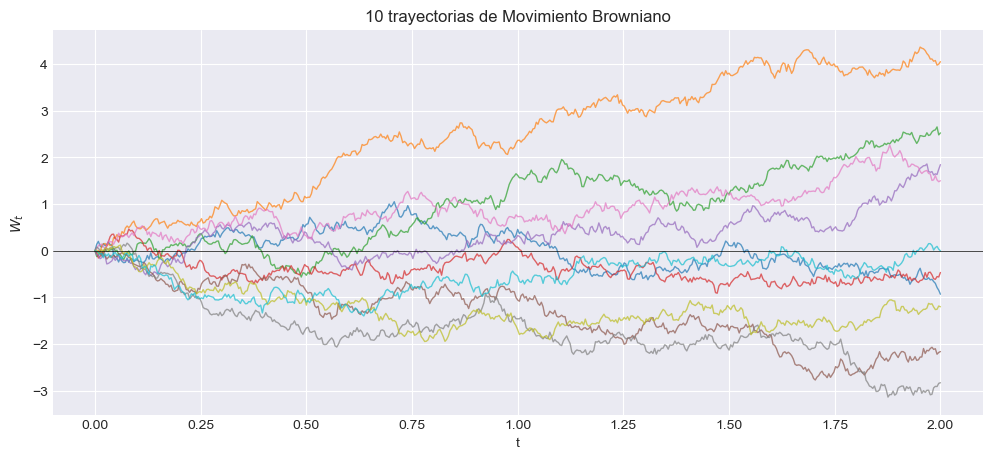

In [13]:
def brownian_motion(T, n_steps, n_paths=1):
    """
    Simula n_paths trayectorias de un movimiento browniano en [0,T] con n_steps pasos.
    Retorna array de forma (n_paths, n_steps+1)
    """
    dt = T / n_steps
    # Incrementos: matriz (n_paths, n_steps)
    dW = np.random.normal(0, np.sqrt(dt), size=(n_paths, n_steps))
    # Acumulación
    W = np.zeros((n_paths, n_steps + 1))
    W[:, 1:] = np.cumsum(dW, axis=1)
    return W

T = 2.0
n_steps = 500
n_paths = 10

W = brownian_motion(T, n_steps, n_paths)
t = np.linspace(0, T, n_steps+1)

plt.figure(figsize=(12, 5))
for i in range(n_paths):
    plt.plot(t, W[i], lw=1, alpha=0.7)
plt.title(f'{n_paths} trayectorias de Movimiento Browniano')
plt.xlabel('t')
plt.ylabel('$W_t$')
plt.axhline(0, color='black', lw=0.5)
plt.show()


**Visualización**: Cada camino es diferente, pero todos parten de cero y fluctúan con amplitud que crece como $\sqrt{t}$.

### De Random Walk a Browniano: escalado de Donsker  
Si tomamos un random walk con pasos de media cero y varianza $\Delta t$, y hacemos $\Delta t \to 0$, obtenemos un movimiento browniano. Ésta es la base de la convergencia de los modelos discretos a continuos.

---

## 3. Procesos de Poisson

Los procesos de Poisson modelan la ocurrencia de eventos discretos en el tiempo: llegada de órdenes, defaults, noticias, saltos en el precio, etc.

### Proceso de Poisson homogéneo $\{N_t\}_{t \ge 0}$
- $N_0 = 0$.
- Incrementos independientes.
- $N_t - N_s \sim \text{Poisson}(\lambda (t-s))$, con $\lambda > 0$ (intensidad).
- Las trayectorias son constantes por tramos, con saltos de tamaño 1 en los tiempos de llegada.

### Tiempos entre llegadas
Los tiempos entre eventos, $\tau_i$, son i.i.d. con distribución exponencial de media $1/\lambda$.

### Simulación de un proceso de Poisson
Podemos simular:
- **Método de los tiempos entre llegadas**: generar exponenciales y acumular.
- **Método de conteo por intervalos**: para cada intervalo pequeño, decidir si ocurre un evento (aproximación binomial).

#### Simulación por tiempos de espera

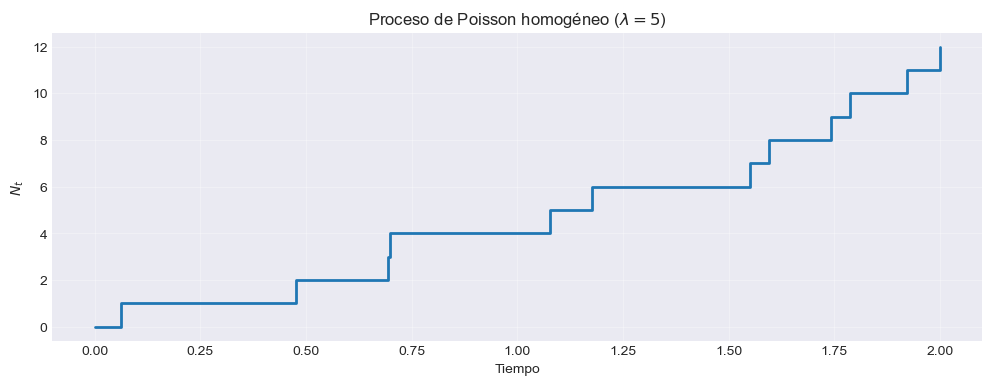

In [21]:
def poisson_process(rate, T):
    """
    Simula un proceso de Poisson homogéneo de intensidad rate en [0,T].
    Retorna: tiempos_de_eventos, N_t (función de conteo evaluada en esos tiempos)
    """
    t = 0
    times = [0]
    while t < T:
        # tiempo hasta próximo evento
        tau = np.random.exponential(1/rate)
        t += tau
        if t < T:
            times.append(t)
    # Añadimos el tiempo final para completar la trayectoria
    times.append(T)
    # Función de conteo: saltos en cada tiempo de evento
    N = np.arange(len(times))
    return np.array(times), N

rate = 5   # eventos por año
T = 2.0
times, N = poisson_process(rate, T)

plt.figure(figsize=(12, 4))
plt.step(times, N, where='post', lw=2)
plt.xlabel('Tiempo')
plt.ylabel('$N_t$')
plt.title(rf'Proceso de Poisson homogéneo ($\lambda = {rate}$)')
plt.grid(alpha=0.3)
plt.show()

#### Simulación por discretización (aproximación binomial)

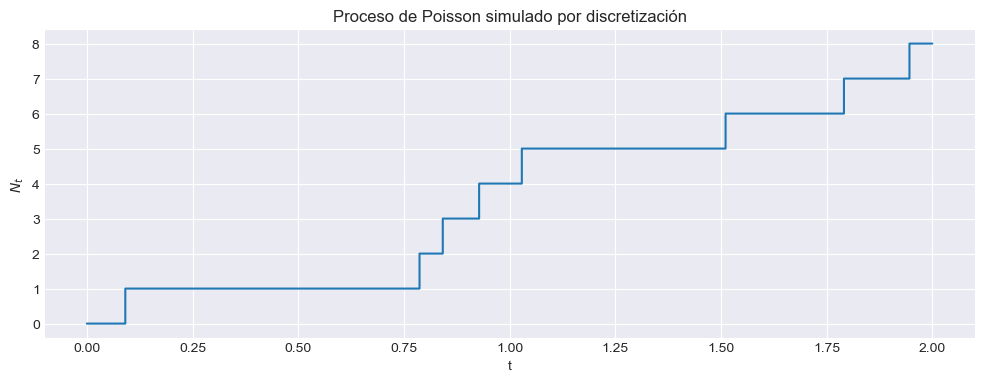

In [15]:
dt = 0.001
n = int(T/dt)
time_grid = np.linspace(0, T, n+1)
dN = np.random.poisson(rate * dt, n)   # nº de eventos en cada dt (casi siempre 0 o 1)
N_sim = np.cumsum(np.concatenate(([0], dN)))
plt.figure(figsize=(12,4))
plt.step(time_grid, N_sim, where='post')
plt.title('Proceso de Poisson simulado por discretización')
plt.xlabel('t')
plt.ylabel('$N_t$')
plt.show()

### Proceso de Poisson compuesto
Añadimos magnitud aleatoria a cada salto:  
$$
X_t = \sum_{i=1}^{N_t} Y_i
$$
donde $Y_i$ son i.i.d. independientes del proceso de Poisson. Esto modela shocks de tamaño variable (ej. impacto de noticias en el precio).

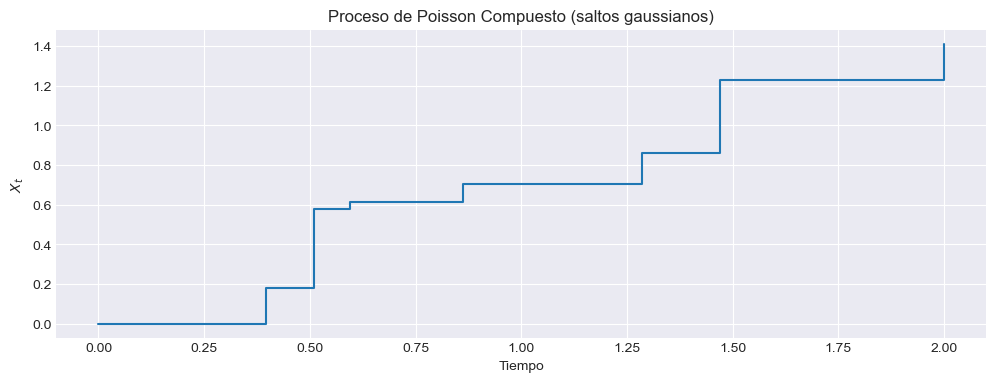

In [16]:
def compound_poisson(rate, T, jump_dist):
    """
    Simula un proceso de Poisson compuesto.
    jump_dist: función que genera una magnitud de salto.
    """
    times, N = poisson_process(rate, T)
    jumps = jump_dist(size=len(N)-1)   # un salto por evento (excepto t=0)
    X = np.zeros_like(times)
    X[1:] = np.cumsum(jumps)           # el proceso acumula los saltos
    return times, X

# Ejemplo: saltos con distribución Normal(0.2, 0.1)
np.random.seed(123)
times, X = compound_poisson(rate=3, T=2, jump_dist=lambda size: np.random.normal(0.2, 0.1, size))

plt.figure(figsize=(12,4))
plt.step(times, X, where='post')
plt.title('Proceso de Poisson Compuesto (saltos gaussianos)')
plt.xlabel('Tiempo')
plt.ylabel('$X_t$')
plt.show()

## 4. Más allá: Difusión con saltos

Combinando el movimiento browniano (para la dinámica continua normal) con un proceso de Poisson compuesto (para eventos raros), obtenemos modelos más realistas que capturan tanto la volatilidad diaria como los saltos extremos. El modelo de **Merton (1976)** para el log-precio es un ejemplo:

$$
d \ln S_t = \left(\mu - \frac{\sigma^2}{2} - \lambda k\right) dt + \sigma dW_t + dJ_t
$$

donde $J_t$ es un proceso de Poisson compuesto con saltos de media $k$. Esto permite que el modelo tenga colas más pesadas (fat tails) como observamos en los datos reales.

### Simulación conjunta (breve ejemplo)

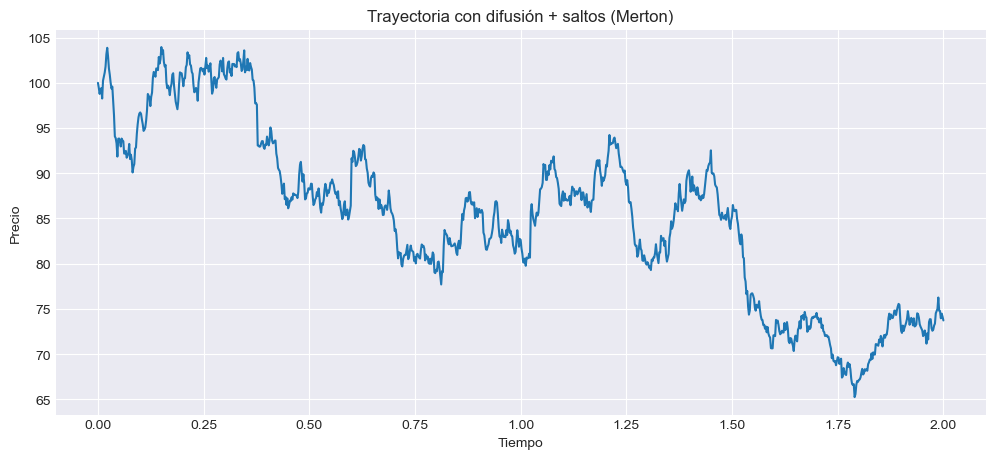

In [17]:
def jump_diffusion(S0, T, n_steps, mu, sigma, lambda_jump, jump_mean, jump_std):
    dt = T / n_steps
    t = np.linspace(0, T, n_steps+1)
    
    # Componente difusiva (GBM)
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    # Componente de saltos (Poisson compuesto)
    n_jumps = np.random.poisson(lambda_jump * dt, n_steps)
    jump_sizes = np.random.normal(jump_mean, jump_std, n_steps) * n_jumps  # suma de saltos en cada dt
    
    # Incrementos del log-precio
    dlogS = (mu - 0.5*sigma**2) * dt + sigma * dW + jump_sizes
    logS = np.log(S0) + np.cumsum(np.concatenate(([0], dlogS)))
    S = np.exp(logS)
    return t, S

t, S = jump_diffusion(100, 2, 1000, mu=0.05, sigma=0.2, lambda_jump=5, jump_mean=0, jump_std=0.05)

plt.figure(figsize=(12,5))
plt.plot(t, S)
plt.title('Trayectoria con difusión + saltos (Merton)')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.show()

---

## Conclusión

- **Random Walk**: modelo discreto simple, base de la eficiencia de mercado.  
- **Movimiento Browniano**: límite continuo del random walk, proceso fundamental para construir modelos de difusión (GBM, Black-Scholes).  
- **Procesos de Poisson**: modelan la ocurrencia de eventos discretos; el Poisson compuesto añade magnitudes aleatorias para representar shocks.  

Estos procesos son los "ladrillos" con los que los quants construyen modelos más complejos que intentan capturar la realidad del mercado: tendencia, volatilidad, agrupamiento de volatilidad (GARCH) y saltos extremos. La combinación de browniano y saltos da lugar a los modelos de **difusión con saltos**, que mejoran el realismo respecto al GBM estándar.

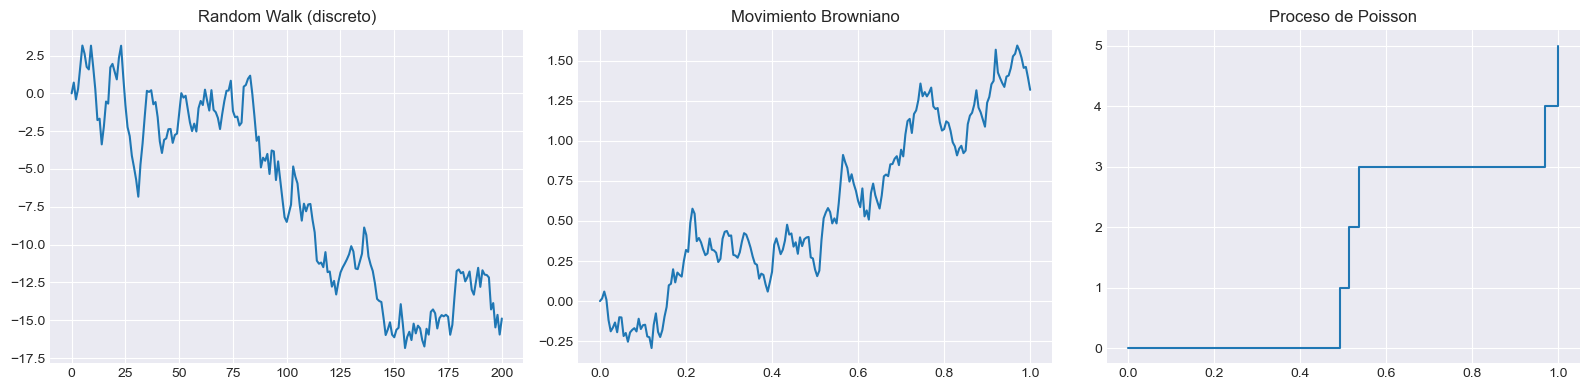

In [18]:
# Resumen gráfico de los tres procesos básicos
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Random Walk
eps = np.random.randn(200)
rw = np.cumsum(np.concatenate(([0], eps)))
axes[0].plot(rw)
axes[0].set_title('Random Walk (discreto)')

# Browniano
t = np.linspace(0, 1, 201)
W = np.cumsum(np.random.normal(0, np.sqrt(1/200), 200))
W = np.concatenate(([0], W))
axes[1].plot(t, W)
axes[1].set_title('Movimiento Browniano')

# Poisson
times, N = poisson_process(rate=5, T=1)
axes[2].step(times, N, where='post')
axes[2].set_title('Proceso de Poisson')

plt.tight_layout()
plt.show()